# Genetics Algorithm for Travelling Salesman Problem
## Implemented in Python
### List of content:
- [Constants](#constants)
- [Setup cities](#setup-cities)
- [Show cities](#show-cities)
- [Show connections between cities](#show-connections)
- [Generate GIF](#generation-of-gif)
- [Compute distance matrix](#compute-distance-matrix)
- [Calculate distance of a route](#calculate-distance-of-a-route)
- [Sort by distance](#sort-by-distance)
- [Generate initial population](#generate-initial-population)
- [Select specimens](#select-specimens)
- [Mutation](#mutation)
- [Crossover](#crossover)
- [Generate children](#generate-children)
- [Succession](#succession)
- [Main loop](#main-loop)
- [Run the main loop](#run-the-main-loop)
- [Plots](#plots)

In [398]:
from tempfile import TemporaryDirectory
from typing import Literal, Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.image as mpimg
from PIL import Image

## Constants

In [379]:
# CONSTANTS AND PARAMETERS
CITIES = 50
POP_SIZE = 50
GENERATIONS = 100
CROSS_PROB = 0.9
MUTATION_PROB = 0.8
TOURNAMENT_SIZE = 6
SELECTION_METHOD: Literal["tournament", "roulette"] = "tournament"
SUCCESSION_METHOD: Literal["full", "partial", "elitist"] = "elitist"
CITIES_X_LIMIT = 300
CITIES_Y_LIMIT = 300

## Setup cities

In [364]:
def setup_cities(n: int, limit_x: int, limit_y: int, shape: Literal["ring", "random"] = "ring") -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate random coordinates for cities.

    :param shape: Shape of the city distribution ('random' or 'ring')
    :param n: Number of cities
    :param limit_x: X-axis limit
    :param limit_y: Y-axis limit
    :return: Array of city coordinates
    """
    match shape:
        case 'random':
            x = np.random.randint(0, limit_x, size=n)
            y = np.random.randint(0, limit_y, size=n)
        case 'ring':
            angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
            center_x, center_y = limit_x // 2, limit_y // 2
            radius_x, radius_y = limit_x // 2, limit_y // 2
            x = (center_x + radius_x * np.cos(angles)).astype(int)
            y = (center_y + radius_y * np.sin(angles)).astype(int)
        case _:
            raise ValueError("Shape must be either random or ring!")

    return x,y


generated_cities = setup_cities(CITIES, CITIES_X_LIMIT, CITIES_Y_LIMIT)

## Show cities

In [365]:
def show_cities(cities: Tuple[np.ndarray, np.ndarray]) -> None:
    """
    Visualize the cities on a scatter plot

    :param cities: Tuple of city coordinates
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(cities[0], cities[1], marker='o')
    plt.xlim(-10, CITIES_X_LIMIT + 10)
    plt.ylim(-10, CITIES_Y_LIMIT + 10)
    plt.title("Cities Distribution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()
    plt.show()

## Show connections

In [366]:
def show_connections(cities: Tuple[np.ndarray, np.ndarray], population: np.ndarray, ind: int, tmpdir: TemporaryDirectory) -> None:
    """
    Show how the cities are connected in the best route.

    :param cities: Tuple of x and y coordinates for cities.
    :param population: The population containing chromosomes (routes) of city indices.
    :param ind: Index
    :param tmpdir: Temporary directory to save the frames.
    :return: The matplotlib figure object.
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(cities[0], cities[1], marker='o')
    plt.xlim(-10, CITIES_X_LIMIT + 10)
    plt.ylim(-10, CITIES_Y_LIMIT + 10)
    plt.title(f"Cities Distribution {ind + 1}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()

    best_route = population[-1]

    # Ensure that best_route contains only valid indices
    best_route = np.clip(best_route, 0, len(cities[0]) - 1)  # Ensures indices are within bounds

    # Draw lines between cities in the best route
    for i in range(len(best_route) - 1):
        # Ensure indices are integers when accessing the cities array
        index1 = int(best_route[i])  # City index from the route
        index2 = int(best_route[i + 1])  # City index from the route

        # Plot line between cities
        x_values = [cities[0][index1], cities[0][index2]]
        y_values = [cities[1][index1], cities[1][index2]]
        plt.plot(x_values, y_values, color='blue')

    plt.savefig(f"{tmpdir}/frame_{ind}.png")
    plt.close()

## Generation of GIF

In [367]:
def generate_gif(cities: Tuple[np.ndarray, np.ndarray], populations: List[np.ndarray]) -> None:
    """
    Generate gif from figures saved in a temporary directory

    :param cities:
    :param populations:
    :return:
    """
    with TemporaryDirectory() as tmpdir:
        for ind, pop in enumerate(populations):
            show_connections(cities, pop, ind, tmpdir)

        frames = [Image.open(f"{tmpdir}/frame_{i}.png") for i in range(len(populations))]
        frames[0].save("cities.gif", save_all=True, append_images=frames[1:], duration=500, loop=0)


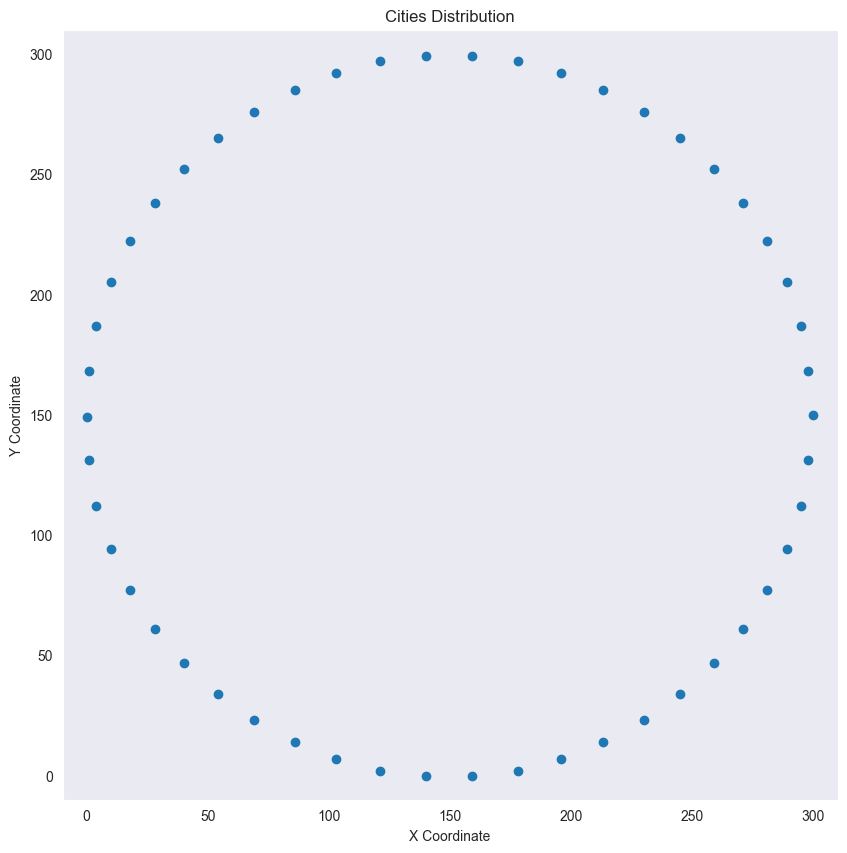

In [368]:
show_cities(generated_cities)

## Compute distance matrix

In [369]:
def compute_distance_matrix(cities: Tuple[np.ndarray, np.ndarray]) -> np.ndarray:
    """
    Compute the Euclidean distance matrix between all pairs of cities to be used later in the calculations

    :param cities: Tuple of city coordinates
    :return: 2D array (matrix) of distances
    """
    x, y = cities
    coords = np.stack((x, y), axis=1)
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    return dist_matrix


distances = compute_distance_matrix(generated_cities)

## Calculate distance of a route

In [370]:
def calculate_distance(chromosome: np.ndarray, dist_matrix: np.ndarray = distances) -> float:
    """
    Calculate the total distance of a given chromosome (route) based on the distance matrix

    :param chromosome: Chromosome representing the route
    :param dist_matrix: Distance matrix between cities
    :return: Total distance of the route
    """
    distance = sum(
        dist_matrix[chromosome[i], chromosome[i - 1]] for i in range(len(chromosome))
    )

    return distance


test_chromosome = np.random.permutation(len(generated_cities))
calculate_distance(test_chromosome, distances)

np.float64(36.22154055254967)

## Sort by distance

In [371]:
def sort_by_distance(chromosome: np.ndarray, distance_col_index: int = -1) -> np.ndarray:
    """
    Sort the population based on their distance

    :param chromosome: 2D numpy array where each row is a chromosome with distance stored in a specific column
    :param distance_col_index: Index of the column containing the distance, because the distance is the last column
    """
    return chromosome[chromosome[:, distance_col_index].argsort()]

## Generate initial population

In [372]:
def generate_initial_population(pop_size: int, num_cities: int) -> np.ndarray:
    """
    Create the initial population of candidate routes

    :param pop_size: Size of the population
    :param num_cities: Total number of cities excluding the start/end city
    :return: Initial population
    """
    population = np.empty((pop_size, num_cities + 1), dtype=int)

    for i in range(pop_size):
        path = np.random.permutation(np.arange(1, num_cities))
        # Start and end at city 0
        route = np.concatenate(([0], path, [0]))

        population[i, :] = route

    distances = np.array([calculate_distance(route) for route in population])
    population = np.column_stack((population, distances))
    return sort_by_distance(population, num_cities + 1)


generate_population = generate_initial_population(POP_SIZE, CITIES)
generate_population

array([[0.00000000e+00, 4.20000000e+01, 2.80000000e+01, ...,
        6.00000000e+00, 0.00000000e+00, 8.80362276e+03],
       [0.00000000e+00, 4.80000000e+01, 6.00000000e+00, ...,
        3.20000000e+01, 0.00000000e+00, 8.85789177e+03],
       [0.00000000e+00, 2.20000000e+01, 3.50000000e+01, ...,
        2.90000000e+01, 0.00000000e+00, 8.86507440e+03],
       ...,
       [0.00000000e+00, 3.00000000e+01, 7.00000000e+00, ...,
        4.60000000e+01, 0.00000000e+00, 1.06518966e+04],
       [0.00000000e+00, 1.50000000e+01, 5.00000000e+00, ...,
        3.90000000e+01, 0.00000000e+00, 1.08362683e+04],
       [0.00000000e+00, 2.30000000e+01, 4.00000000e+00, ...,
        3.40000000e+01, 0.00000000e+00, 1.09303699e+04]], shape=(50, 52))

## Select specimens

In [373]:
def select_specimens(original_generation: np.ndarray,
                     parent_count: int,
                     selection_type: Literal["roulette", "tournament"] = "tournament",
                     tournament_size: int = TOURNAMENT_SIZE,
                     with_replacement: bool = True) -> np.ndarray:
    """
    Selects specimens from a generation based on a given selection strategy

    :param original_generation: np.ndarray of specimens
    :param parent_count: Number of parents to select.
    :param selection_type: Selection strategy
    :param tournament_size: Size of tournament
    :param with_replacement: Whether to allow the same specimen to be selected multiple times
    :return: np.ndarray of selected parents sorted by fitness
    """
    generation = original_generation.copy()

    match selection_type:
        case "tournament":
            selected_parents = []
            available_indexes = np.arange(generation.shape[0])

            # Ensure we select exactly parent_count specimens
            while len(selected_parents) < parent_count:
                tournament_indexes = np.random.choice(available_indexes, size=tournament_size, replace=False)
                tournament_specimens = generation[tournament_indexes]
                tournament_winner = tournament_specimens[np.argmin(tournament_specimens[:, -1])]
                selected_parents.append(tournament_winner)

                if not with_replacement:
                    winner_index = np.where(generation == tournament_winner)[0][0]
                    available_indexes = np.delete(available_indexes, np.where(available_indexes == winner_index)[0])

            selected = np.unique(np.vstack(selected_parents), axis=0)

        case "roulette":
            distances = generation[:, -1]
            # Small epsilon to avoid division by zero
            probabilities = 1 / (distances + 1e-6)
            probabilities /= np.sum(probabilities)

            selected_indices = []

            while len(selected_indices) < parent_count:
                selected_index = np.random.choice(np.arange(generation.shape[0]), p=probabilities)
                # Remember, no duplicates ;)
                while selected_indices.count(selected_index) >= 1:
                    selected_index = np.random.choice(np.arange(generation.shape[0]), p=probabilities)
                selected_indices.append(selected_index)

            selected = generation[selected_indices]
            selected = np.unique(selected, axis=0)

        case _:
            raise ValueError("Invalid selection type. Choose either tournament or roulette!")

    # Ensure that we return exactly parent_count specimens after sorting by fitness
    return sort_by_distance(selected)[:parent_count]


## Mutation

In [374]:
def mutation(chromosome: np.ndarray,
             mutation_probability: float = MUTATION_PROB,
             num_cities: int = CITIES,
             mutation_method: Literal["full", "partial"] = "full") -> np.ndarray:
    """
    Mutate a chromosome by swapping two cities with a given probability

    :param num_cities:
    :param mutation_method: full mutation means ver1 and ver2 of mutation, while partial mutation means only ver1
    :param chromosome: Chromosome to mutate
    :param mutation_probability: Probability of mutation
    :return: Mutated chromosome
    """
    # If selected random value if larger skip mutation
    if np.random.rand() < mutation_probability:
        specimen = chromosome.copy()

        # Swap two random cities (except the starting/ending city), we don't take the last column into account
        first_ind, second_ind = np.random.choice(np.arange(1, num_cities - 1), size=2, replace=False)
        first_gene = specimen[first_ind]
        second_gene = specimen[second_ind]
        specimen[second_ind] = first_gene
        specimen[first_ind] = second_gene

        if mutation_method == "full":
            first_ind, second_ind = np.random.choice(np.arange(1, num_cities - 1), size=2, replace=False)
            tmp_spec = specimen[first_ind].copy()
            if first_ind > second_ind:
                specimen[second_ind + 1: first_ind + 1] = specimen[second_ind: first_ind]
            else:
                specimen[first_ind: second_ind] = specimen[first_ind + 1: second_ind + 1]
            specimen[second_ind] = tmp_spec

        return specimen

    return chromosome

## Crossover

In [375]:
def crossover(
    parent1: np.ndarray,
    parent2: np.ndarray,
    crossover_probability: float = CROSS_PROB,
    crossover_method: Literal["order", "simple"] = "order",
    num_cities: int = CITIES,
) -> np.ndarray:
    """
    Perform crossover between two parents to create a child.

    :param parent1: First parent chromosome
    :param parent2: Second parent chromosome
    :param crossover_probability: Probability of crossover
    :param crossover_method: Crossover method
    :param num_cities:
    :return: Child chromosome
    """
    if np.random.rand() < crossover_probability:
        # Randomly select two crossover points
        start, end = sorted(np.random.choice(np.arange(1, num_cities - 1), size=2, replace=True))
        child = np.full_like(parent1, -1)

        match crossover_method:
            case "order":
                # Slice from parent1
                child[start:end + 1] = parent1[start:end + 1]
                fill_index = (end + 1) % num_cities
                for gene in parent2:
                    if gene not in child:
                        child[fill_index] = gene
                        fill_index = (fill_index + 1) % num_cities

            case "simple":
                # Slice from parent2 and shuffle it
                slice_to_shuffle = parent2[start:end + 1].copy()
                np.random.shuffle(slice_to_shuffle)

                # Fill child
                child[start:end + 1] = slice_to_shuffle

                # Fill rest from parent1
                for i in range(num_cities):
                    if i < start or i > end:
                        child[i] = parent1[i]

            case _:
                raise ValueError("Invalid crossover method. Choose either order or simple!")

    return parent1.copy()

## Generate children

In [376]:
def generate_children(
    parents: np.ndarray,
    child_count: int = POP_SIZE,
    crossover_probability: float = CROSS_PROB,
    mutation_probability: float = MUTATION_PROB,
    crossover_method: Literal["order", "simple"] = "order",
) -> np.ndarray:
    """
    Generate children from parents using crossover and mutation.

    :param parents: Parent chromosomes
    :param child_count: Number of children to generate
    :param crossover_probability: Probability of crossover
    :param mutation_probability: Probability of mutation
    :param crossover_method: Crossover method
    :return: Generated children
    """
    children = []

    # Number of cities (including repeated 0) from one parent route
    num_cities_with_return = parents.shape[1] - 1

    while len(children) < child_count:
        ind1, ind2 = np.random.choice(np.arange(parents.shape[0]), size=2, replace=True)

        # Remove distance column
        parent1, parent2 = parents[ind1, :-1], parents[ind2, :-1]

        child = crossover(parent1, parent2, crossover_probability=crossover_probability, crossover_method=crossover_method)
        child = mutation(child, mutation_probability=mutation_probability)

        # Trim to valid route length just in case
        child = child[:num_cities_with_return].astype(int)

        # Calculate and append distance
        distance = calculate_distance(child)
        child_with_distance = np.append(child, distance)

        children.append(child_with_distance)

    return sort_by_distance(np.array(children))


## Succession

In [377]:
def succession(
        parent_generation: np.ndarray,
        children_generation: np.ndarray,
        population_size: int = POP_SIZE,
        successsion_method: Literal["full", "partial", "elitist"] = SUCCESSION_METHOD,
        selection_method: Literal["roulette", "tournament"] = SELECTION_METHOD,
        elitist_count: int = 5
) -> np.ndarray:
    """
    Perform succession to create the next generation by applying the selected inheritance method.

    :param parent_generation: The parent generation chromosomes
    :param children_generation: The child generation chromosomes
    :param population_size: The desired population size of the next generation
    :param successsion_method: The succession method to apply
    :param selection_method: The selection method to apply
    :param elitist_count: How many best specimens to keep in each new generation
    :return: The next generation chromosomes
    """
    complete_pop = np.vstack([parent_generation, children_generation])

    if successsion_method == "full":
        # Inherit only the children
        return sort_by_distance(children_generation)

    elif successsion_method == "partial":
        best_elite = sort_by_distance(complete_pop)[:elitist_count]
        remainder_count = population_size - elitist_count
        if selection_method == "roulette":
            remainder = select_specimens(complete_pop, selection_type='roulette', parent_count=remainder_count, with_replacement=True)
        else:
            remainder = select_specimens(complete_pop, selection_type='tournament', parent_count=remainder_count, with_replacement=True)

        next_generation = np.vstack([best_elite, remainder])
        return sort_by_distance(next_generation)[:population_size]

    elif successsion_method == "elitist":
        # Sort and slice to exactly POP_SIZE
        return sort_by_distance(complete_pop)[:population_size]

    else:
        raise ValueError("Invalid successsion_method. Choose from 'full', 'partial', or 'elitist'.")

## Main loop

In [390]:
def main_loop(
        generations: int,
        generated_cities: Tuple[np.ndarray, np.ndarray],
        population_size: int = POP_SIZE,
        mutation_probability: float = MUTATION_PROB,
        crossover_probability: float = CROSS_PROB,
        selection_method: Literal["roulette", "tournament"] = SELECTION_METHOD,
        successsion_method: Literal["full", "partial", "elitist"] = SUCCESSION_METHOD,
) -> Tuple[List, List, List, int]:
    """
    Main loop of the genetic algorithm.

    :param generations: Number of generations to run
    :param generated_cities: Generated cities
    :param population_size: Size of the population
    :param mutation_probability: Probability of mutation
    :param crossover_probability: Probability of crossover
    :param selection_method: Selection method
    :param successsion_method: Succession method
    :return: Best chromosome from the last generation
    """
    population = generate_initial_population(population_size, CITIES)

    all_populations = [population]
    mean_distances = []
    min_distances = []
    max_distances = []
    final_generation = 0

    for generation in range(generations):
        if selection_method == "roulette":
            selected_parents = select_specimens(population, parent_count=population_size, selection_type='roulette', with_replacement=True)
        else:
            selected_parents = select_specimens(population, parent_count=population_size, selection_type='tournament', with_replacement=True)

        children = generate_children(selected_parents, child_count=population_size, crossover_probability=crossover_probability, mutation_probability=mutation_probability)

        population = succession(population, children, population_size=population_size, successsion_method=successsion_method, selection_method=selection_method)
        population = sort_by_distance(population)
        all_populations.append(population)
        best_distance = population[0, -1]
        mean_distances.append(population[:, -1].mean())
        min_distances.append(population[:, -1].min())
        max_distances.append(population[:, -1].max())
        final_generation += 1

        # check if the best distance does not change between chromosomes
        if np.isclose(population[:, -1].std(), 0) and np.isclose(population[:, -1].mean(), best_distance):
            print(f"Early stopping at generation {generation + 1}")
            break

        print(f"Generation {generation+1}, Smallest Distance: {best_distance}")

    generate_gif(generated_cities, all_populations)
    return mean_distances, min_distances, max_distances, final_generation


## Run the main loop

In [391]:
# Run the main loop for 100 generations
cities = setup_cities(POP_SIZE, CITIES_X_LIMIT, CITIES_Y_LIMIT, shape="ring")
mean_dist, min_dist, max_dist, final_gen = main_loop(GENERATIONS, cities, POP_SIZE, mutation_probability=MUTATION_PROB, crossover_probability=CROSS_PROB, selection_method=SELECTION_METHOD, successsion_method=SUCCESSION_METHOD)

Generation 1, Smallest Distance: 8348.176959198423
Generation 2, Smallest Distance: 7662.358341921523
Generation 3, Smallest Distance: 7662.358341921523
Generation 4, Smallest Distance: 7579.519633955288
Generation 5, Smallest Distance: 7360.767995255185
Generation 6, Smallest Distance: 7206.63008345295
Generation 7, Smallest Distance: 7127.684139925551
Generation 8, Smallest Distance: 7111.976976440108
Generation 9, Smallest Distance: 6725.723890096172
Generation 10, Smallest Distance: 6523.280917975221
Generation 11, Smallest Distance: 6271.024255255014
Generation 12, Smallest Distance: 6271.024255255014
Generation 13, Smallest Distance: 6192.023653159315
Generation 14, Smallest Distance: 6167.288253707311
Generation 15, Smallest Distance: 6167.288253707311
Generation 16, Smallest Distance: 5970.794640221861
Generation 17, Smallest Distance: 5778.895851200783
Generation 18, Smallest Distance: 5778.895851200783
Generation 19, Smallest Distance: 5778.895851200783
Generation 20, Smalles

## Plots

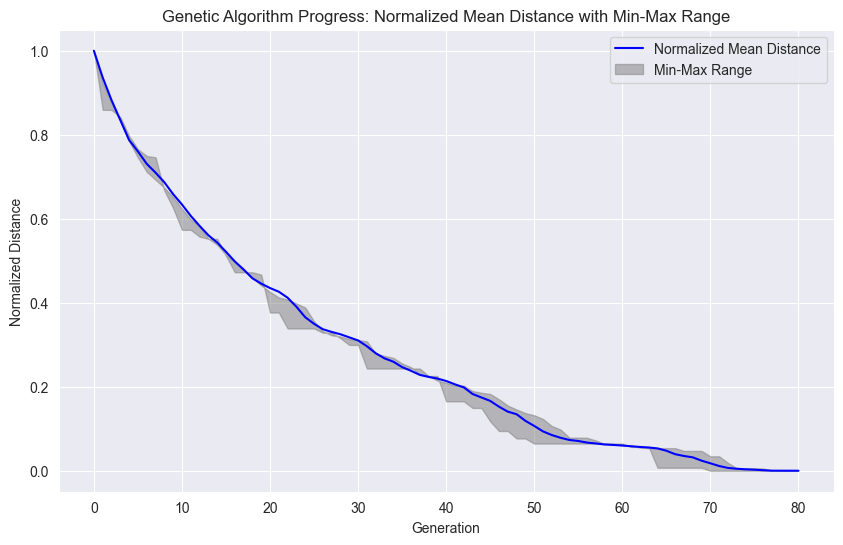

In [394]:
def normalize(values: np.ndarray) -> np.ndarray:
    return (values - np.min(values)) / (np.max(values) - np.min(values))


mean_dist_norm = normalize(np.array(mean_dist))
min_dist_norm = normalize(np.array(min_dist))
max_dist_norm = normalize(np.array(max_dist))

plt.figure(figsize=(10, 6))
plt.plot(range(final_gen), mean_dist_norm, label='Normalized Mean Distance', color='blue')
plt.fill_between(range(final_gen), min_dist_norm, max_dist_norm, color='gray', alpha=0.5, label='Min-Max Range')
plt.title("Genetic Algorithm Progress: Normalized Mean Distance with Min-Max Range")
plt.xlabel("Generation")
plt.ylabel("Normalized Distance")
plt.legend()
plt.show()

<video width="640" height="480" controls>
  <source src="cities.mp4" type="video/mp4">
  <a href=>You can still see the gif here :)</a>
</video>